# Transferencia de Aprendizaje para la Clasificación de Flores con EfficientNet

In [19]:
# Importacion de librerias
import os
import time
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt  
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [20]:
# Fijamos las semillas para reproductibilidad
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

## Descargando el dataset

El dataset que usaremos es uno de flores el cual contiene 104 clases. Lo puedes decargar en este enlace https://www.kaggle.com/competitions/flower-classification-with-tpus. Asegurate de modificar la variable `data_dir` a tu directorio en donde descargarás el dataset.

In [21]:
BATCH_SIZE=32
IMAGE_SIZE = [224, 224]  
AUTO = tf.data.AUTOTUNE

def decode_image(image_data):
    """Convierte bytes a imagen y aplica preprocesamiento de ResNet"""
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image

def read_labeled_tfrecord(example):
    """Parsea un tfrecord con imagen + etiqueta"""
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),  # la imagen como bytes
        "class": tf.io.FixedLenFeature([], tf.int64),   # la etiqueta
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def load_dataset_from_folder(folder):
    filenames = tf.io.gfile.glob(os.path.join(folder, "*.tfrec"))

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)  
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)   
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [22]:
# Rutas
dataset_dir = "DATASETS/flower-classification-with-tpus/tfrecords-jpeg-224x224"
train_folder = f"{dataset_dir}/train"
val_folder   = f"{dataset_dir}/val"
test_folder  = f"{dataset_dir}/test"

# Cargar datasets
train_ds = load_dataset_from_folder(train_folder)
val_ds   = load_dataset_from_folder(val_folder)
test_ds  = load_dataset_from_folder(test_folder)

In [23]:
# Verificamos que tanto las dimensiones como las etiquetas sean correctas.
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

Images shape: (32, 224, 224, 3)
Labels shape: (32,)


In [24]:
# Aumentamos los datos de entrenamiento
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)


## Modelo

Usaremos efficientnet como extractor de características, y agregaremos una capa densa de clasificación al final con 104 neuronas (el número de clases).

In [25]:
NUM_CLASSES = 104  

# Cargar ResNet-50 preentrenada en ImageNet
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,      # quitamos la capa de clasificación original
    weights='imagenet',     # pesos preentrenados
    input_shape=(224, 224, 3)
)

# Congelar la base si quieres transfer learning
base_model.trainable = False

# Crear modelo completo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilar modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 104)              

## Entrenamiento del Modelo

Comprobamos que el modelo puede memorizar con pocos datos, esto con el fin de verificar que la arquitectura sea correcta.

In [26]:
small_batch = train_ds.take(1)

model.fit(
    small_batch,
    epochs=20
)

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 4.6411 - accuracy: 0.0312
Epoch 2/20
1/1 [==============================] - 1s 765ms/step - loss: 4.2535 - accuracy: 0.0625
Epoch 3/20
1/1 [==============================] - 1s 800ms/step - loss: 3.4880 - accuracy: 0.3125
Epoch 4/20
1/1 [==============================] - 1s 737ms/step - loss: 3.1856 - accuracy: 0.3438
Epoch 5/20
1/1 [==============================] - 1s 785ms/step - loss: 2.8811 - accuracy: 0.4375
Epoch 6/20
1/1 [==============================] - 1s 842ms/step - loss: 2.1144 - accuracy: 0.5625
Epoch 7/20
1/1 [==============================] - 1s 757ms/step - loss: 1.8679 - accuracy: 0.6875
Epoch 8/20
1/1 [==============================] - 1s 759ms/step - loss: 1.4207 - accuracy: 0.8125
Epoch 9/20
1/1 [==============================] - 1s 768ms/step - loss: 1.2222 - accuracy: 0.8438
Epoch 10/20
1/1 [==============================] - 1s 695ms/step - loss: 0.9757 - accuracy: 0.8750
Epoch 11/20
1/1 [=====

el modelo es capaz de aprender pocos datos, entonces podemos continuar con el entrenamiento completo

In [27]:
start_time = time.time()

EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1               
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {elapsed_time:.2f} segundos")

Epoch 1/10
399/399 [==============================] - 228s 571ms/step - loss: 1.9425 - accuracy: 0.5374 - val_loss: 0.9659 - val_accuracy: 0.7584
Epoch 2/10
399/399 [==============================] - 165s 412ms/step - loss: 1.1495 - accuracy: 0.6929 - val_loss: 0.7723 - val_accuracy: 0.7969
Epoch 3/10
399/399 [==============================] - 157s 393ms/step - loss: 0.9705 - accuracy: 0.7338 - val_loss: 0.7088 - val_accuracy: 0.8130
Epoch 4/10
399/399 [==============================] - 163s 407ms/step - loss: 0.8945 - accuracy: 0.7502 - val_loss: 0.6717 - val_accuracy: 0.8268
Epoch 5/10
399/399 [==============================] - 154s 385ms/step - loss: 0.8498 - accuracy: 0.7595 - val_loss: 0.6343 - val_accuracy: 0.8367
Epoch 6/10
399/399 [==============================] - 159s 397ms/step - loss: 0.7966 - accuracy: 0.7762 - val_loss: 0.6535 - val_accuracy: 0.8378
Epoch 7/10
399/399 [==============================] - 160s 401ms/step - loss: 0.7749 - accuracy: 0.7789 - val_loss: 0.6346 -

Veamos las gráficas de entrenamiento y validación.

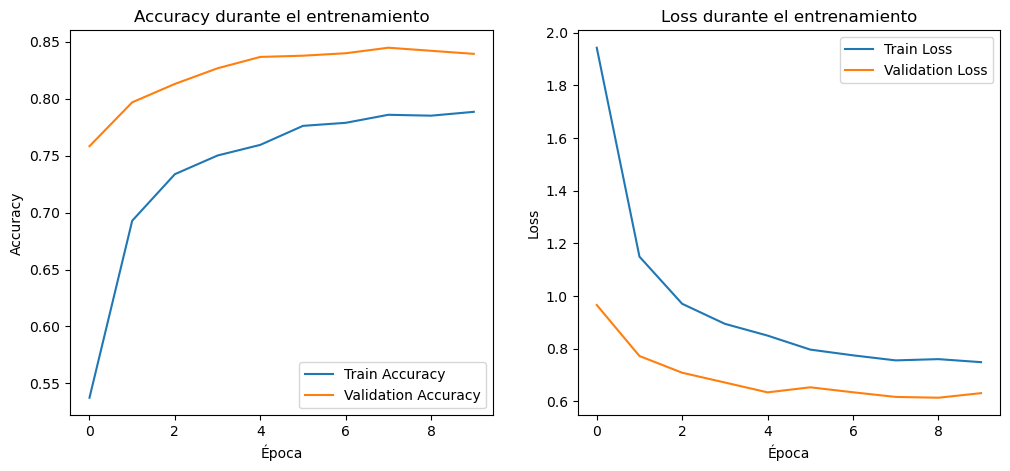

In [28]:
# Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()

Se muestran estables y las dos convergen en la misma dirección, con lo cual el entrenamiento del modelo fue exitoso. Procedemos a almacenar el modelo

In [29]:
# Guardamos el modelo
model.save("model.h5")

/home/lcc_rn_08/.conda/envs/medium/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Resultados 

Probamos en nuestro conjunto de validación diferentes métricas para ver la calidad de nuestro modelo.

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Valores verdaderos.
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Valores predichos por el modelo.
probs = model.predict(val_ds)
y_pred = np.argmax(probs, axis = 1)

116/116 [==============================] - 35s 293ms/step


In [31]:
# Metricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy (Global): {acc:.4f}")
print(f"Precision (Weighted): {prec:.4f}")
print(f"Recall (Weighted):    {rec:.4f}")
print(f"F1-Score (Weighted):  {f1:.4f}")

Accuracy (Global): 0.8394
Precision (Weighted): 0.8504
Recall (Weighted):    0.8394
F1-Score (Weighted):  0.8387


Vemos que obtenemos resultados bastante buenos, veamos como es por cada clase con la matriz de confusion y con metricas por clase.

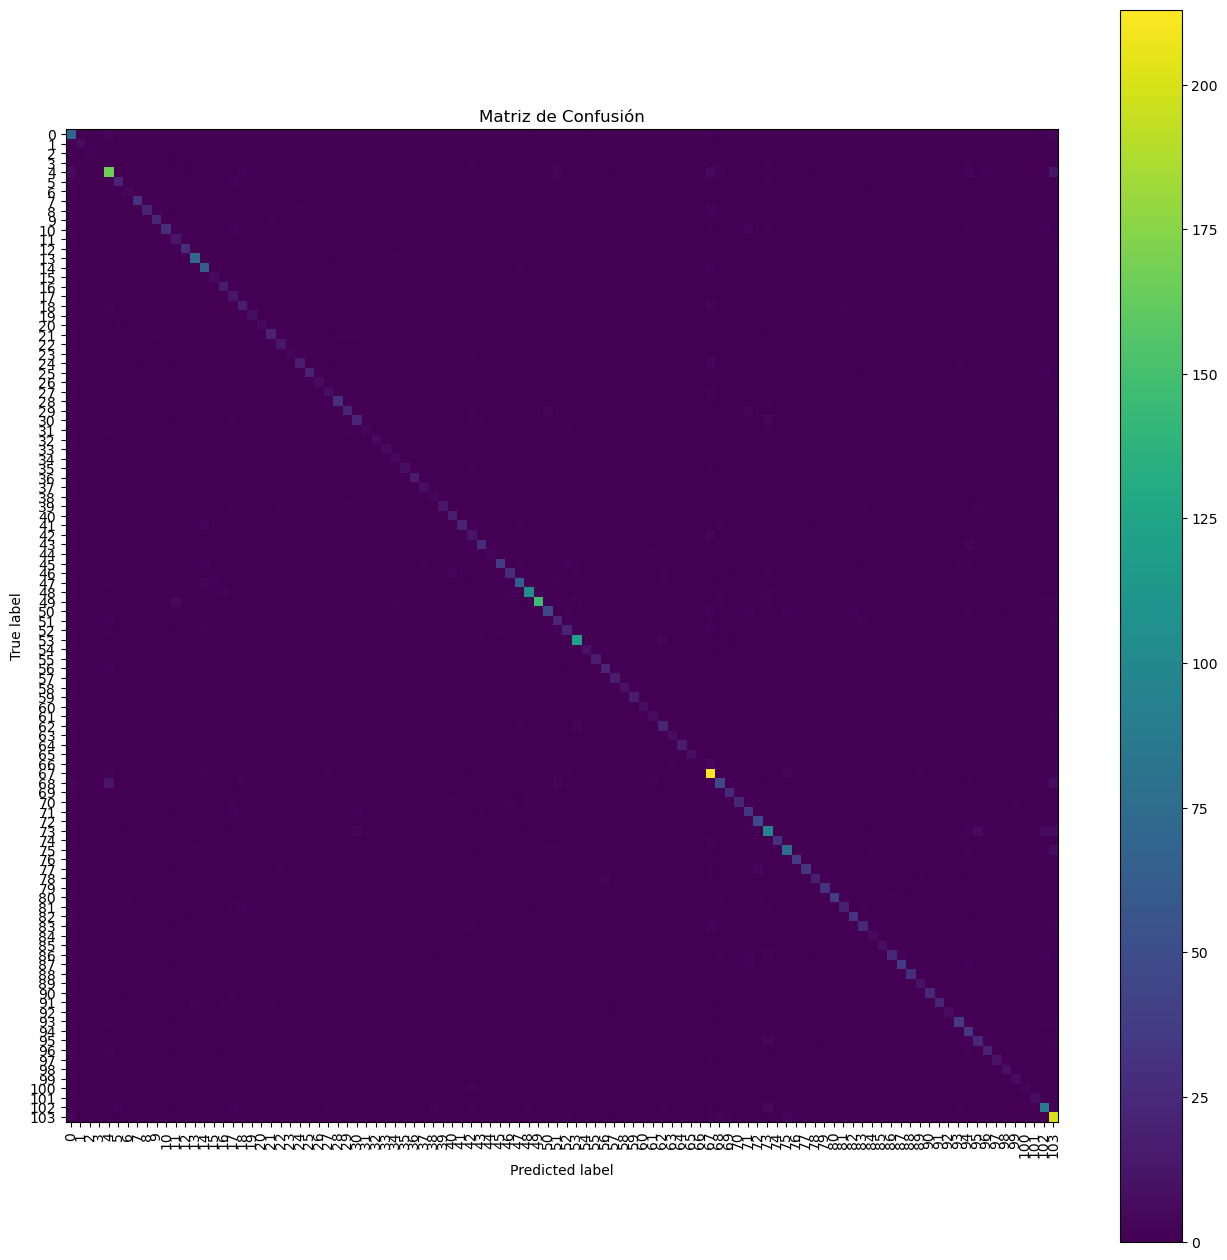

In [32]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(16, 16))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(
    include_values=False,     
    cmap='viridis',           
    ax=ax,                    
    xticks_rotation='vertical'
)

plt.title('Matriz de Confusión')
plt.show()

Se muestra la diagonal con un color diferente, indicandonos que el modelo si identifíca bien todas las clases. Veamos el reporte de clasificación por cada clase

In [33]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        79
           1       1.00      0.86      0.92         7
           2       1.00      0.33      0.50         6
           3       1.00      0.17      0.29         6
           4       0.84      0.81      0.83       205
           5       0.80      0.80      0.80        25
           6       0.80      0.80      0.80         5
           7       1.00      0.97      0.98        31
           8       0.95      0.80      0.87        25
           9       0.96      0.96      0.96        24
          10       0.66      0.72      0.69        40
          11       0.72      1.00      0.84        13
          12       1.00      0.96      0.98        27
          13       0.90      0.96      0.93        77
          14       0.82      0.95      0.88        66
          15       0.67      1.00      0.80         6
          16       0.80      1.00      0.89        16
          17       0.48    

Vemos que el reporte coincide con la matriz de confusion.

## Modelo sin transfern learning

Vamos a definir una CNN sencilla para ver si la elección de transfern learning fue la adecuada

In [43]:
model_no_tl = models.Sequential([
    # Bloque 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2,2)),

    # Bloque 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Bloque 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Clasificación
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Lo compilamos
model_no_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
# Comprobamos si el modelo puede memorizar pocos datos
small_batch = train_ds.take(1)

model_no_tl.fit(
    small_batch,
    epochs=20
)

Epoch 1/20
1/1 [==============================] - 0s 485ms/step - loss: 3.2289 - accuracy: 0.2812
Epoch 2/20
1/1 [==============================] - 0s 452ms/step - loss: 3.4009 - accuracy: 0.1562
Epoch 3/20
1/1 [==============================] - 0s 469ms/step - loss: 2.6211 - accuracy: 0.3438
Epoch 4/20
1/1 [==============================] - 0s 446ms/step - loss: 2.1502 - accuracy: 0.4688
Epoch 5/20
1/1 [==============================] - 0s 476ms/step - loss: 3.2153 - accuracy: 0.2188
Epoch 6/20
1/1 [==============================] - 0s 456ms/step - loss: 2.0966 - accuracy: 0.4688
Epoch 7/20
1/1 [==============================] - 0s 473ms/step - loss: 2.1918 - accuracy: 0.4375
Epoch 8/20
1/1 [==============================] - 0s 466ms/step - loss: 2.5871 - accuracy: 0.1875
Epoch 9/20
1/1 [==============================] - 0s 466ms/step - loss: 1.8907 - accuracy: 0.4375
Epoch 10/20
1/1 [==============================] - 0s 466ms/step - loss: 1.5545 - accuracy: 0.5938
Epoch 11/20
1/1 [==

In [45]:
# Entrenamiento completo
start_time = time.time()

EPOCHS_NO_TL = 10

history_no_tl = model_no_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_NO_TL,
    verbose=1               
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {elapsed_time:.2f} segundos")

Epoch 1/10


399/399 [==============================] - 120s 301ms/step - loss: 3.9547 - accuracy: 0.1023 - val_loss: 3.6309 - val_accuracy: 0.1536
Epoch 2/10
399/399 [==============================] - 120s 301ms/step - loss: 3.5481 - accuracy: 0.1524 - val_loss: 3.3105 - val_accuracy: 0.1921
Epoch 3/10
399/399 [==============================] - 120s 299ms/step - loss: 3.3086 - accuracy: 0.1960 - val_loss: 3.2172 - val_accuracy: 0.2058
Epoch 4/10
399/399 [==============================] - 117s 292ms/step - loss: 3.1112 - accuracy: 0.2164 - val_loss: 3.0378 - val_accuracy: 0.2384
Epoch 5/10
399/399 [==============================] - 120s 300ms/step - loss: 2.9816 - accuracy: 0.2486 - val_loss: 2.8340 - val_accuracy: 0.2759
Epoch 6/10
399/399 [==============================] - 119s 298ms/step - loss: 2.8693 - accuracy: 0.2657 - val_loss: 2.7871 - val_accuracy: 0.2864
Epoch 7/10
399/399 [==============================] - 119s 297ms/step - loss: 2.7797 - accuracy: 0.2833 - val_loss: 2.7247 - val_accura

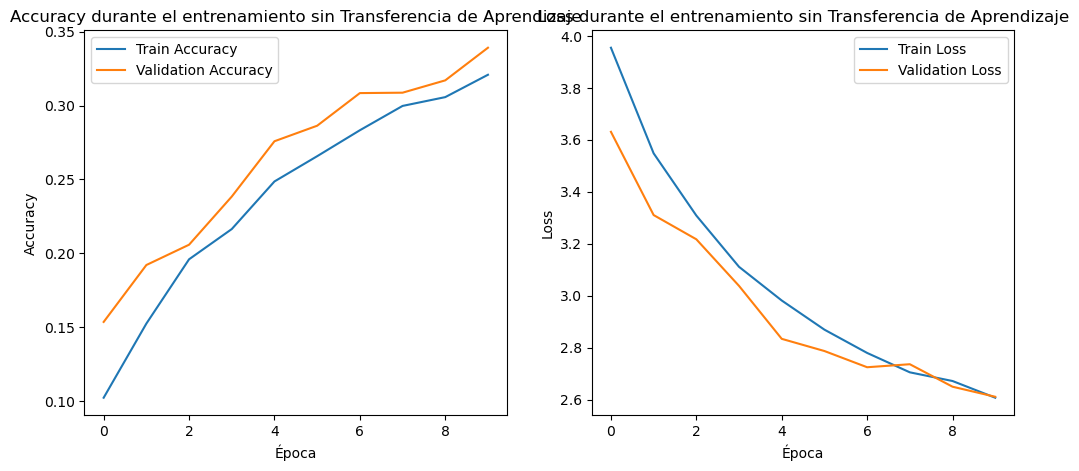

In [46]:
# Gráficas
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_no_tl.history['accuracy'], label='Train Accuracy')
plt.plot(history_no_tl.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento sin Transferencia de Aprendizaje')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_no_tl.history['loss'], label='Train Loss')
plt.plot(history_no_tl.history['val_loss'], label='Validation Loss')
plt.title('Loss durante el entrenamiento sin Transferencia de Aprendizaje')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [47]:
# Valores predichos por el modelo.
probs_no_tl = model_no_tl.predict(val_ds)
y_pred_no_tl = np.argmax(probs_no_tl, axis = 1)

116/116 [==============================] - 8s 72ms/step


In [48]:
# Metricas
acc_no_tl = accuracy_score(y_true, y_pred_no_tl)
prec_no_tl = precision_score(y_true, y_pred_no_tl, average='weighted')
rec_no_tl = recall_score(y_true, y_pred_no_tl, average='weighted')
f1_no_tl = f1_score(y_true, y_pred_no_tl, average='weighted')

print(f"Accuracy (Global): {acc_no_tl:.4f}")
print(f"Precision (Weighted): {prec_no_tl:.4f}")
print(f"Recall (Weighted):    {rec_no_tl:.4f}")
print(f"F1-Score (Weighted):  {f1_no_tl:.4f}")

Accuracy (Global): 0.3392
Precision (Weighted): 0.3379
Recall (Weighted):    0.3392
F1-Score (Weighted):  0.2984


/home/lcc_rn_08/.conda/envs/medium/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
